# Create a visual accompaigniment to our manuscript with input subconnectome top connections colored by module

This will require:
1. Getting bodyIds for each of the top inputs we want to include, as well as their cluster numbers
2. Getting the skeletons for each of those bodyIDs 
3. Plotting those Ids on a black background and seeing how that looks

In [68]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import bokeh
import bokeh.palettes
from bokeh.plotting import figure, output_notebook, show, output_file, gridplot
from bokeh.io import export_svg, export_png
from bokeh.models import Legend, LegendItem
import os
from neuprint import Client, fetch_adjacencies, fetch_skeleton
# settings
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["font.sans-serif"] = "Helvetica"
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

auth_token_file = open("flybrain.auth.txt", 'r') # need file containing the authentication token
auth_token = next(auth_token_file).strip()
try:
    np_client = Client('neuprint.janelia.org', dataset='hemibrain:v1.2.1', token=auth_token)
except:
    np_client = None

output_notebook()

Loading BokehJS ...

## Define Colors

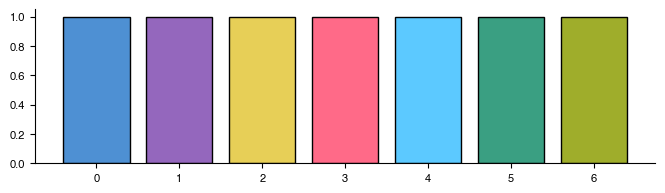

In [69]:
colors = ['#4e90d3', '#9467bd', '#e7cf57', '#ff6a88', '#5cc9ff', '#3a9f82', '#9fad2b']
colors

# plot darker colors
plt.figure(figsize=(8,2))
for i, color in enumerate(colors):
    plt.bar(i, 1, color=color, edgecolor='black')

In [70]:
# import modularity data for oviIN
oviIN_R = 423101189
oviIN_modularity = pd.read_csv('modularity_runs/0.0/0-0_98765.txt', sep=' ', header=None, names=['id', '0.0'])
oviIN_modularity

,id,0.0
0,1003215282,1
1,1005952640,2
2,1006928515,3
3,1007260806,3
4,1008024276,4
...,...,...
1827,987117151,2
1828,987273073,6
1829,988567837,5
1830,988909130,5


In [71]:
# fetch connections between oviIN and its partners
oviIN_partners, connections = fetch_adjacencies(None, oviIN_R)
connections

,bodyId_pre,bodyId_post,roi,weight
0,234630133,423101189,CRE(R),2
1,263674097,423101189,SMP(R),2
2,266187480,423101189,SMP(R),1
3,266187559,423101189,SMP(R),3
4,267214250,423101189,SMP(R),9
...,...,...,...,...
3526,6400000773,423101189,SMP(R),2
3527,7112622044,423101189,SIP(R),1
3528,7112622044,423101189,SMP(R),1
3529,7112622044,423101189,SMP(L),1


In [72]:
connections_grouped = connections[['bodyId_pre', 'bodyId_post', 'weight']].groupby(['bodyId_pre', 'bodyId_post']).sum().reset_index()
connections_grouped

,bodyId_pre,bodyId_post,weight
0,234630133,423101189,2
1,263674097,423101189,2
2,266187480,423101189,1
3,266187559,423101189,3
4,267214250,423101189,9
...,...,...,...
2519,5901231318,423101189,1
2520,5901232053,423101189,3
2521,6400000773,423101189,2
2522,7112622044,423101189,3


In [73]:
# merging oviIN modularity with its connections
ovi_conn = connections_grouped.merge(oviIN_modularity, left_on='bodyId_pre', right_on='id').drop(columns=['bodyId_pre', 'bodyId_post'])
# sort weight column
ovi_conn = ovi_conn.sort_values(by='weight', ascending=False)
ovi_conn

,weight,id,0.0
562,287,611015907,1
1782,255,5813087891,2
1484,243,1598011458,2
1642,236,5813022375,5
204,225,448342846,5
...,...,...,...
1408,1,1263646693,2
1409,1,1283173461,2
372,1,544611593,1
371,1,544265891,1


In [100]:
# Take the top 150 rows
top_ovi_conn = ovi_conn.head(50)
top_ovi_conn

,weight,id,0.0
562,287,611015907,1
1782,255,5813087891,2
1484,243,1598011458,2
1642,236,5813022375,5
204,225,448342846,5
337,168,517242832,1
608,165,635908014,1
453,157,576574889,1
612,156,636944318,1
322,148,514850616,3


In [101]:
# Get skeleton plots for the top 150 partners
skeletons_all = []
for bodyId in top_ovi_conn['id']:
        skeletons = []
        # could add more skeletons with a for loop
        #s = c.fetch_skeleton(oviINr_bodyID, format='pandas')
        s = np_client.fetch_skeleton(body=bodyId, format='pandas')
        s['bodyId'] = bodyId
        s['color'] = colors[top_ovi_conn.loc[top_ovi_conn['id'] == bodyId]['0.0'].values[0]-1]

        skeletons.append(s)

        # Combine into one big table for convenient processing
        skeletons = pd.concat(skeletons, ignore_index=True)

        # Join parent/child nodes for plotting as line segments below.
        # (Using each row's 'link' (parent) ID, find the row with matching rowId.)
        segments = skeletons.merge(skeletons, 'inner',
                                left_on=['bodyId', 'link'],
                                right_on=['bodyId', 'rowId'],
                                suffixes=['_child', '_parent'])
        skeletons_all.append(segments)

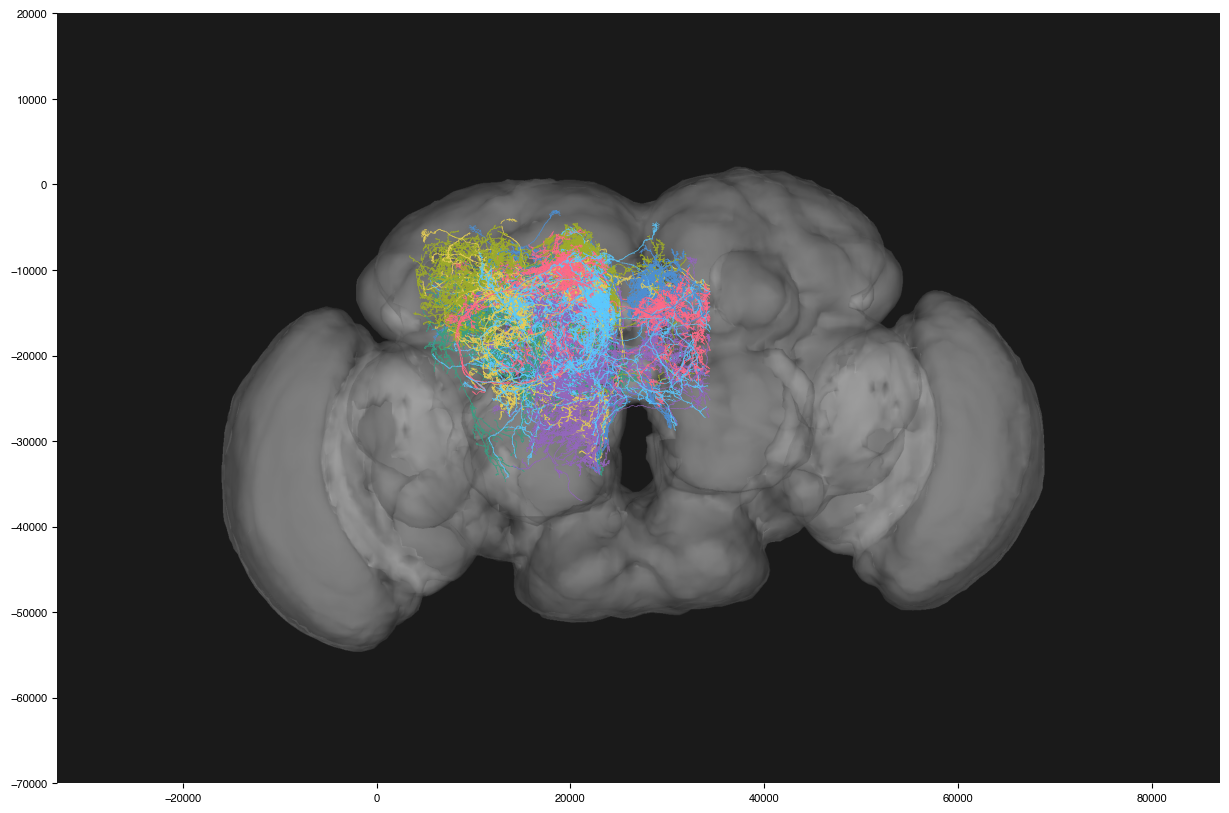

In [105]:
# import picture to plot over
image = plt.imread('/Users/rweberla/Desktop/hemibrain_outline.png')
# Create a matplotlib figure
fig, ax = plt.subplots(figsize=(15, 10))
# Plot the image
ax.imshow(image, extent=[-33000, 87000, -70000, 20000], aspect='auto')


# Plot each skeleton
for segments in skeletons_all:
    for index, row in segments.iterrows():
        # plot the parent-child connections, and reflect across the y-axis
        ax.plot([row['x_child'], row['x_parent']], [-row['z_child'], -row['z_parent']],
            color=row['color_child'], linewidth=0.5, alpha=0.7)
# flip only the y-axis for the plotting
#ax.set_ylim(ax.get_ylim()[::-1])

# Set axis limits
# dont display figure outline
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)



In [ ]:
# save pmpre to pdf
from bokeh.io import export_svg, export_png
export_svg(p, filename="/Users/rweberla/Desktop/synaptic_sites_skeleton_smallateral.svg")

[]

In [ ]:
export_png(p, filename="/Users/rweberla/Desktop/synaptic_sites_skeleton_smalllateral.png")